In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import math
from glob import glob
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

Global seed set to 0


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/trajectory_inference/cm_lineage/eb_cm_lineage.pseudotime.adata")

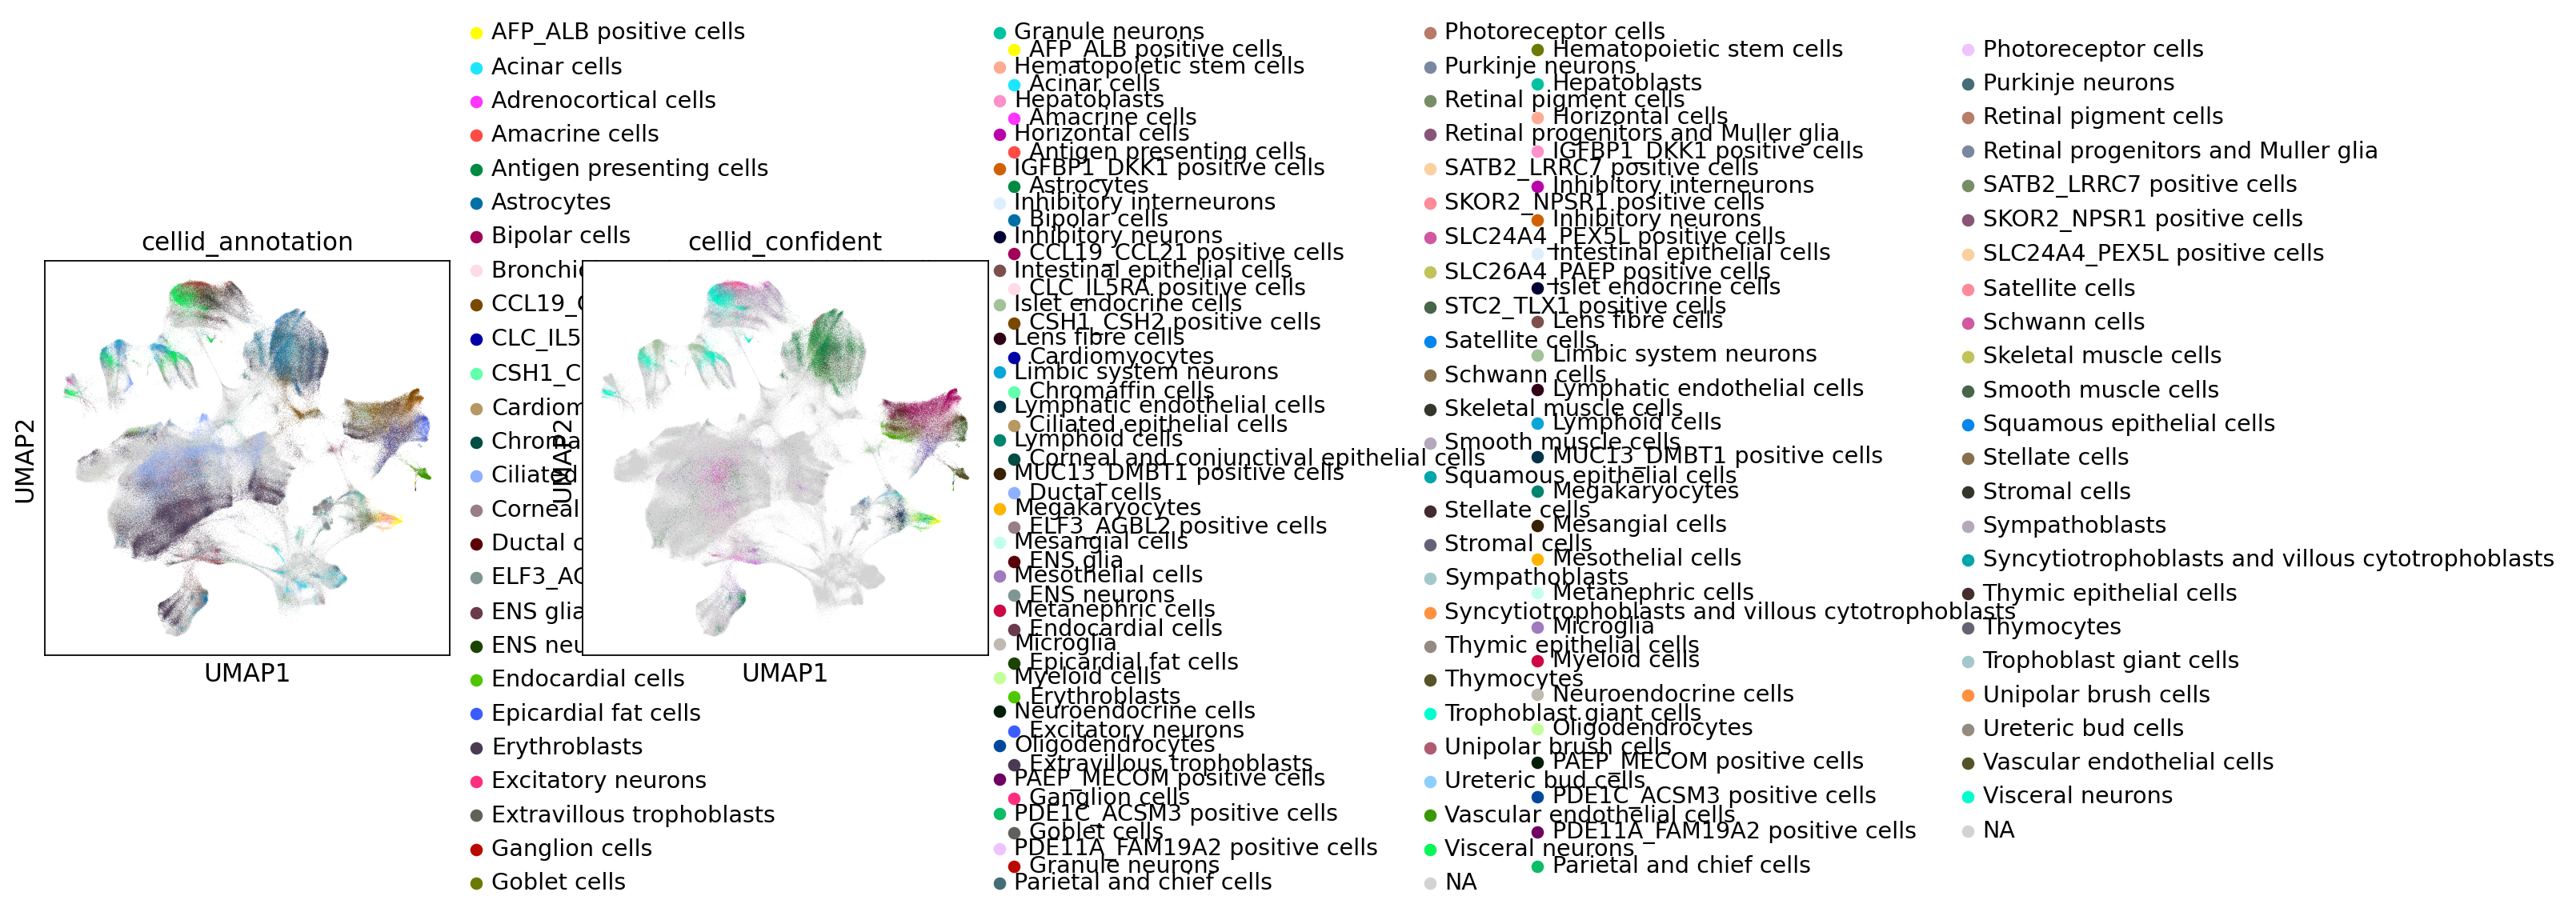

In [6]:
sc.pl.pca(adata, color=["stage"])

## Sample Summary

How many cells we have for each individual in each cell type?

In [7]:
cell_counts = adata.obs[['stage', 'donor_id']]
cell_counts = cell_counts[~cell_counts['stage'].isnull()]
cell_counts = pd.DataFrame(cell_counts.groupby('stage').value_counts()).reset_index(inplace=False).rename(columns={0: "n_cells", 'stage': 'type'})
cell_counts

,cellid_annotation,donor_id_x,n_cells
0,AFP_ALB positive cells,NA18862,354
1,AFP_ALB positive cells,NA19144,260
2,AFP_ALB positive cells,NA19114,223
3,AFP_ALB positive cells,NA19152,180
4,AFP_ALB positive cells,NA18499,174
...,...,...,...
3922,Visceral neurons,NA18913,29
3923,Visceral neurons,NA19108,16
3924,Visceral neurons,NA19203,4
3925,Visceral neurons,NA18907,3


To get this into proper form, we need to:
- Reformat cell types
- Add a column of nUMIs per sample (we don't need these for this analysis so we'll leave it as NaN for now)

In [8]:
cell_counts['individual'] = [s.replace("NA", "") for s in cell_counts['donor_id']]
cell_counts['n_umi'] = np.nan
cell_counts['ind_type'] = cell_counts['individual'].astype(str) + "_" + cell_counts['type'].astype(str)
cell_counts = cell_counts[['ind_type', 'n_umi', 'individual', 'type', 'n_cells']]
cell_counts

,ind_type,n_umi,individual,type,n_cells
0,18862_AFP-ALB-positive-cells,NaN,18862,AFP-ALB-positive-cells,354
1,19144_AFP-ALB-positive-cells,NaN,19144,AFP-ALB-positive-cells,260
2,19114_AFP-ALB-positive-cells,NaN,19114,AFP-ALB-positive-cells,223
3,19152_AFP-ALB-positive-cells,NaN,19152,AFP-ALB-positive-cells,180
4,18499_AFP-ALB-positive-cells,NaN,18499,AFP-ALB-positive-cells,174
...,...,...,...,...,...
3922,18913_Visceral-neurons,NaN,18913,Visceral-neurons,29
3923,19108_Visceral-neurons,NaN,19108,Visceral-neurons,16
3924,19203_Visceral-neurons,NaN,19203,Visceral-neurons,4
3925,18907_Visceral-neurons,NaN,18907,Visceral-neurons,3


We'll drop any samples with less than 5 cells

In [9]:
cell_counts['dropped'] = cell_counts['n_cells'] < 5

In [34]:
cell_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/highpass_cellid_all/pseudobulk-scran/sample_summary.tsv",
                  sep="\t", index=False)

## Cell Type Summary

We will filter to samples with at least 5 cells, and cell types with over 25 individuals represented.

In [11]:
ind_counts = cell_counts[cell_counts['n_cells'] >= 5]
ind_counts = pd.DataFrame(ind_counts[['type']].value_counts()).reset_index(inplace=False).rename(columns={0: "n"})
ind_counts = ind_counts[ind_counts['n']>25]
ind_counts

,type,n
0,AFP-ALB-positive-cells,51
1,Ciliated-epithelial-cells,51
2,Erythroblasts,51
3,Astrocytes,51
4,CCL19-CCL21-positive-cells,51
5,Mesangial-cells,50
6,Islet-endocrine-cells,50
7,Corneal-and-conjunctival-epithelial-cells,50
8,Limbic-system-neurons,50
9,Vascular-endothelial-cells,49


In [12]:
list(ind_counts['type'])

['AFP-ALB-positive-cells',
 'Ciliated-epithelial-cells',
 'Erythroblasts',
 'Astrocytes',
 'CCL19-CCL21-positive-cells',
 'Mesangial-cells',
 'Islet-endocrine-cells',
 'Corneal-and-conjunctival-epithelial-cells',
 'Limbic-system-neurons',
 'Vascular-endothelial-cells',
 'Amacrine-cells',
 'Visceral-neurons',
 'Oligodendrocytes',
 'Skeletal-muscle-cells',
 'CLC-IL5RA-positive-cells',
 'Ganglion-cells',
 'Smooth-muscle-cells',
 'IGFBP1-DKK1-positive-cells',
 'Photoreceptor-cells',
 'Acinar-cells',
 'Microglia',
 'Trophoblast-giant-cells',
 'Bipolar-cells',
 'Satellite-cells',
 'SLC24A4-PEX5L-positive-cells',
 'ENS-glia',
 'ENS-neurons',
 'Hepatoblasts',
 'Purkinje-neurons',
 'Granule-neurons',
 'Cardiomyocytes',
 'Metanephric-cells',
 'Epicardial-fat-cells']

In [35]:
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/highpass_cellid_all/pseudobulk-scran/samples_per_celltype.tsv",
                  sep="\t", index=False)

## Pseudobulk Aggregation

First, we can highlight which samples will be kept for QTL analysis

In [14]:
cell_types_inc = ind_counts['type']

In [15]:
samples_inc = cell_counts[(cell_counts['dropped'] == False) & (cell_counts['type'].isin(cell_types_inc))]['ind_type']
samples_inc

0       18862_AFP-ALB-positive-cells
1       19144_AFP-ALB-positive-cells
2       19114_AFP-ALB-positive-cells
3       19152_AFP-ALB-positive-cells
4       18499_AFP-ALB-positive-cells
                    ...             
3919          19257_Visceral-neurons
3920          19152_Visceral-neurons
3921          19128_Visceral-neurons
3922          18913_Visceral-neurons
3923          19108_Visceral-neurons
Name: ind_type, Length: 1437, dtype: object

In [16]:
cell_subset = adata.obs[['cellid_annotation', 'donor_id_x']]
cell_subset['type'] = [s.replace(" ", "-").replace("_", "-") for s in cell_subset['cellid_annotation'].astype(str)]
cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
cell_subset['sample'] = cell_subset['ind'] + "_" + cell_subset['type']
cell_subset = cell_subset[cell_subset['sample'].isin(samples_inc)]
cell_subset

/tmp/jobs/21257002/ipykernel_114029/2273128244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['type'] = [s.replace(" ", "-").replace("_", "-") for s in cell_subset['cellid_annotation'].astype(str)]
/tmp/jobs/21257002/ipykernel_114029/2273128244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
/tmp/jobs/21257002/ipykernel_114029/2273128244.py:4: SettingWithCopyWarning: 
A value is trying to be set on

,cellid_annotation,donor_id_x,type,ind,sample
cell,,,,,
CCACTTGGTACGTAGG-82,Astrocytes,NA19127,Astrocytes,19127,19127_Astrocytes
AGAGAGCCAGCAGGAT-64,Microglia,NA18508,Microglia,18508,18508_Microglia
GCATCTCCACTCCGAG-79,CCL19_CCL21 positive cells,NA18862,CCL19-CCL21-positive-cells,18862,18862_CCL19-CCL21-positive-cells
GGGTTATTCGAAGCCC-39,CLC_IL5RA positive cells,NA18522,CLC-IL5RA-positive-cells,18522,18522_CLC-IL5RA-positive-cells
TACAGGTAGTTAGTGA-100,Erythroblasts,NA19114,Erythroblasts,19114,19114_Erythroblasts
...,...,...,...,...,...
CTCTCAGTCGTGTTCC-78,Metanephric cells,NA18489,Metanephric-cells,18489,18489_Metanephric-cells
CGGAACCAGCTCACTA-30,Limbic system neurons,NA18520,Limbic-system-neurons,18520,18520_Limbic-system-neurons
CCGGGTACACACGTGC-39,Mesangial cells,NA18522,Mesangial-cells,18522,18522_Mesangial-cells


For pseudobulk aggregation, we're going to use the scran-normalized data

In [17]:
scran_adata = sc.read_h5ad("/project2/gilad/ktayeb/ebqtl-workflowr/output/proc/EB_high_pass_filtered_normalized.h5ad")

In [18]:
scran_adata = scran_adata[cell_subset.index]

In [19]:
scran_adata

View of AnnData object with n_obs × n_vars = 312468 × 35324
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'leiden_coarse', 'sizeFactor', 'scranGroup', 'scranCluster'
    var: 'gene_ids', 'feature_types'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 

To compute the mean, we're first going to get a one-hot encoding of the sample assignment for each cell

In [20]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['sample']])
onehot

<312468x1437 sparse matrix of type '<class 'numpy.float64'>'
	with 312468 stored elements in Compressed Sparse Row format>

In [21]:
n_cells = onehot.sum(axis=0)

In [22]:
pseudobulk_sum = scran_adata.X.transpose() * onehot

In [23]:
pseudobulk_mean = pseudobulk_sum / n_cells

In [24]:
pseudobulk_mean = pd.DataFrame(pseudobulk_mean, 
             index=scran_adata.var_names, columns=cell_subset['sample'].astype("category").cat.categories)

In [25]:
pseudobulk_mean.to_csv("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass_cellid_all.pseudobulk-scran.tsv",
                  sep="\t", index_label="gene")

### Check that pseudobulk aggregation is correct

In [26]:
pseudobulk_mean

,18486_AFP-ALB-positive-cells,18486_Acinar-cells,18486_Amacrine-cells,18486_Astrocytes,18486_Bipolar-cells,18486_CCL19-CCL21-positive-cells,18486_CLC-IL5RA-positive-cells,18486_Ciliated-epithelial-cells,18486_Corneal-and-conjunctival-epithelial-cells,18486_ENS-glia,...,19257_Oligodendrocytes,19257_Photoreceptor-cells,19257_Purkinje-neurons,19257_SLC24A4-PEX5L-positive-cells,19257_Satellite-cells,19257_Skeletal-muscle-cells,19257_Smooth-muscle-cells,19257_Trophoblast-giant-cells,19257_Vascular-endothelial-cells,19257_Visceral-neurons
MIR1302-2HG,0.000000,0.000000,0.000000,0.002426,0.000000,0.000718,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL627309.1,0.027238,0.006236,0.019015,0.005289,0.030563,0.008674,0.019299,0.005473,0.015546,0.008813,...,0.000000,0.016553,0.000000,0.000000,0.018822,0.000000,0.000000,0.041253,0.007607,0.000000
AL627309.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL627309.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC136616.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC023491.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004985,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC007325.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC007325.4,0.065532,0.057560,0.018950,0.051150,0.021224,0.049923,0.031041,0.136722,0.153623,0.036392,...,0.054412,0.273054,0.213328,0.153011,0.089247,0.197029,0.049105,0.621932,0.107287,0.282374


In [27]:
test_cells = cell_subset[cell_subset['sample']=="18486_Astrocytes"]
test = scran_adata[test_cells.index]
test

View of AnnData object with n_obs × n_vars = 706 × 35324
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'leiden_coarse', 'sizeFactor', 'scranGroup', 'scranCluster'
    var: 'gene_ids', 'feature_types'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_

In [31]:
list(test.var_names).index("MIR1302-2HG")

0

In [32]:
np.mean(test.X[:,0])

0.002425742